<a href="https://colab.research.google.com/github/jiho-kang/Data_Analysis_Project/blob/main/%5Bproject2%5D_Movies_on_streaming_platform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Movies on Netflix, Prime Video, Hulu and Disney+
스트리밍 플랫폼(Netflix, Prime Video, Hulu and Disney+)에 올라온 영화의 정보로 평점 예측하기


    > ID : 영화 식별번호
    > Title
    > Year: 방영년도
    > Age: 연령층
    > IMDb: 시청률
    > Rotten Tomatoes: 평점 (target)
    > Netfilx, Hulu, Prime Video, Disney+ : 해당 플랫폼에서 찾을 수 있으면 1, 없으면 0
    > Directors: 여러명 입력 가능
    > Genre: 여러개 입력 가능
    > Country: 여러 나라 입력 가능
    > Language: 여러 언어 입력 가능
    > Runtime

### 데이터 가져오기 및 파악하기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 999

In [ ]:
import pandas as pd
df_ori = pd.read_csv('/content/drive/MyDrive/MoviesOnStreamingPlatforms_updated.csv', )
df_ori = df_ori.iloc[:,2:]
df_ori.head()

,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [ ]:
df_ori.columns

Index(['Title', 'Year', 'Age', 'IMDb', 'Rotten Tomatoes', 'Netflix', 'Hulu',
       'Prime Video', 'Disney+', 'Type', 'Directors', 'Genres', 'Country',
       'Language', 'Runtime'],
      dtype='object')

In [ ]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9515 non-null   object 
 1   Year             9515 non-null   int64  
 2   Age              5338 non-null   object 
 3   IMDb             9309 non-null   object 
 4   Rotten Tomatoes  9508 non-null   object 
 5   Netflix          9515 non-null   int64  
 6   Hulu             9515 non-null   int64  
 7   Prime Video      9515 non-null   int64  
 8   Disney+          9515 non-null   int64  
 9   Type             9515 non-null   int64  
 10  Directors        9104 non-null   object 
 11  Genres           9399 non-null   object 
 12  Country          9261 non-null   object 
 13  Language         9202 non-null   object 
 14  Runtime          9196 non-null   float64
dtypes: float64(1), int64(6), object(8)
memory usage: 1.1+ MB


In [ ]:
df_ori.isnull().sum()

Title                 0
Year                  0
Age                4177
IMDb                206
Rotten Tomatoes       7
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           411
Genres              116
Country             254
Language            313
Runtime             319
dtype: int64

## 모델1
- target: rotten tomatoes' 
- features: drop.target

### 전처리

#### Target: 'Rotten Tomatoes'
- null행 삭제
- '/100' 삭제
- astype('float')

In [ ]:
#target 값이 없는 행은 제거
df_01 = df_ori.copy()
print(len(df_01))

target = 'Rotten Tomatoes'
df_01 = df_01.dropna(subset=[target])
print(len(df_01))

df_01[target] = df_01[target].str.replace('/100','').astype('float')
df_01[target].dtype

9515
9508


dtype('float64')

In [ ]:
df_01.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           406
Genres              113
Country             249
Language            308
Runtime             315
dtype: int64

#### Age
- '+'제거
- all -> 0
- astype('float')

  Age는 순서는 있어도 그 폭과는 상관 없다. target encoder로 처리될 수 있도록 fillna('missing')처리

In [ ]:
# Age
df_02 = df_01.copy()

df_02.Age = df_02.Age.str.replace('+','').replace('all',0)
df_02.Age = df_02.Age.astype('float')
print(df_02.Age.value_counts(dropna=False))

df_02.info()

NaN     4170
18.0    2276
7.0     1090
13.0     998
0.0      698
16.0     276
Name: Age, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   object 
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9102 non-null   object 
 11  Genres           9395 non-null   object 
 12  Country          9259 non-null   object 
 13  Language         9200 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: f

#### IMDb
- '/10'제거
- astype('float')

In [ ]:
# IMDb
df_03 = df_02.copy()

df_03.IMDb = df_03.IMDb.str.replace('/10','')
df_03.IMDb = pd.to_numeric(df_03.IMDb)

df_03.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   float64
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9102 non-null   object 
 11  Genres           9395 non-null   object 
 12  Country          9259 non-null   object 
 13  Language         9200 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.2+ MB


In [ ]:
# 위 코드보다 아래 코드가 memory, time usage에서 어떠한지 확인해보기
data["IMDb"] = [float(score[0:3]) for score in data["IMDb"]]
data["Rotten Tomatoes"] = [float(score[0:2]) for score in data["Rotten Tomatoes"]]

#### Gneres, Director, Country, Language
- fillna('missing') -> 어차피 target encoder로 평균으로 채워주기 때문에 굳이 필요가 없었다.

In [ ]:
df_03.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors           406
Genres              113
Country             249
Language            308
Runtime             315
dtype: int64

In [ ]:
df_04 = df_03.copy()
cols = ['Genres', 'Directors', 'Country', 'Language']
df_04[cols] = df_04[cols].fillna('missing')
df_04.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors             0
Genres                0
Country               0
Language              0
Runtime             315
dtype: int64

### Feature Engineering

In [ ]:
df = df_04.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   float64
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9508 non-null   object 
 11  Genres           9508 non-null   object 
 12  Country          9508 non-null   object 
 13  Language         9508 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.2+ MB


In [ ]:
df.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors             0
Genres                0
Country               0
Language              0
Runtime             315
dtype: int64

#### 시리즈 여부

In [ ]:
# 시리즈물인지 아닌지 여부

In [ ]:
# df[df.Title.str.isdigit() | df.Title.str.contains(':')].sort_values('Title').head(100)

In [ ]:
# df.info()

#### count or IMDb 값 높은 Genre, Directors top 5

In [ ]:
def topk(column):
  eachs = set()
  for sample in df[column].unique():
    try:
      sample = sample.split(',')
      eachs.update(sample)
    except: pass

  each_count = dict()
  for each in eachs:
    count = df[df[column].str.contains(each)].shape[0]
    average = df[df[column].str.contains(each)]['IMDb'].sum() / count
    each_count[each] = [count, round(average,2)]
  
  by_count = sorted(each_count.items(), key = (lambda x: x[1]), reverse=True)
  count_top5 = [i[0] for i in by_count[:5]]

  by_imdb = sorted(each_count.items(), key = (lambda x: x[1][1]), reverse=True)
  imdb_top5 = [i[0] for i in by_imdb[:5]]

  return count_top5, imdb_top5

genre_count_top5, genre_imdb_top5 = topk('Genres')
director_count_top5, director_imdb_top５ = topk('Directors')



In [ ]:
# check_genre = list(set(genre_count_top5 + genre_imdb_top5))
check_director = list(set(director_count_top5 + director_imdb_top５))
check_genre = genre_imdb_top5
# check_director = director_imdb_top５
print(check_genre)
print(check_director)

['Biography', 'History', 'Documentary', 'Film-Noir', 'News']
['Matt Docter', 'PJ Moynihan', 'missing', 'Jay Chapman', 'Ram', 'Raúl Campos', 'Dennis M. Lynch', 'Amadeusz Kocan', 'Jan Suter', 'Jason Docter']


In [ ]:
df['check_gerne'] = df.Genres.apply(lambda x: 1 if any(i in x for i in check_genre) else 0)
df['check_director'] = df.Directors.apply(lambda x: 1 if any(i in x for i in check_director) else 0)
print('dirctor')
print(df.check_director.value_counts(normalize=True))
print(df.check_gerne.value_counts(normalize=True))

dirctor
0    0.946676
1    0.053324
Name: check_director, dtype: float64
0    0.823096
1    0.176904
Name: check_gerne, dtype: float64


### model 학습

#### 데이터 split

In [ ]:
from sklearn.model_selection import train_test_split

# train, val, test
def split(df):
  train_ori, test = train_test_split(df)
  train, val = train_test_split(train_ori)
  len(train), len(val), len(test)

  X_train = train.drop(columns=target)
  y_train = train[target]

  X_val = val.drop(columns=target)
  y_val = val[target]

  X_test = test.drop(columns=target)
  y_test = test[target]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split(df)

#### 기본모델

In [ ]:
pip install --upgrade category_encoders

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X_train2, y_train2, X_val2, y_val2, X_test2, y_test2 = split(df_04)

pipe2 = make_pipeline(
    TargetEncoder(),
    SimpleImputer(),
    XGBRegressor()    
)


pipe2.fit(X_train2, y_train2)
pipe2.score(X_val2,y_val2) # 특성공학 전 모델의 검증 정확도

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[15:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.6347532301844219

#### 모델 학습

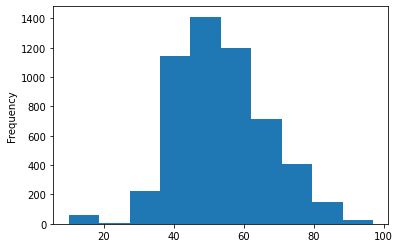

In [ ]:
from matplotlib.pyplot import plot

y_train.plot.hist()

In [ ]:
# processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

# X_train_ready = processor.fit_transform(X_train, y_train)
# X_val_ready = processor.transform(X_val)
# X_test_ready = processor.transform(X_test)

# eval_set = [(X_train_ready, y_train), (X_val_ready, y_val)]


# dists = {'n_estimators': randint(20,500),
#          'learning_rate': [0.01, 0.1, 1,5],
#          'max_depth': randint(5,20),
#          'scale_pos_weight' : [4,5],
#          'gamma': [0.5, 1, 1.5, 2, 5],
#          'reg_alpha': [0.0001, 0.001, 0.1, 1],
#          'reg_lambda': [0.0001, 0.001, 0.1, 1]

#          }

# fit_paras = {'early_stopping_rounds':20,
#              'eval_set': [[X_val_encoded, y_val]]
#              }


# clf = RandomizedSearchCV(XGBRegressor,
#                          cv=3,
#                          param_distributions = dists,
#                          n_iter = 10,
#                          scoring = 'r2',
#                          n_jobs = -1)

# clf.fit(X_train, y_train)


In [ ]:
df.isnull().sum()

Title                 0
Year                  0
Age                4170
IMDb                199
Rotten Tomatoes       0
Netflix               0
Hulu                  0
Prime Video           0
Disney+               0
Type                  0
Directors             0
Genres                0
Country               0
Language              0
Runtime             315
check_gerne           0
check_director        0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   float64
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9508 non-null   object 
 11  Genres           9508 non-null   object 
 12  Country          9508 non-null   object 
 13  Language         9508 non-null   object 
 14  Runtime          9193 non-null   float64
 15  check_gerne      9508 non-null   int64  
 16  check_director   9508 non-null   int64  
dtypes: float64(4),

In [ ]:
# 지금 이거로 하는 중
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

X_train_ready = processor.fit_transform(X_train, y_train)
X_val_ready = processor.transform(X_val)
X_test_ready = processor.transform(X_test)
# X_train_ori_ready = processor.transform(train_ori.drop(columns=target))

eval_set = [(X_train_ready, y_train), (X_val_ready, y_val)]


dists = {'n_estimators': randint(20,500),
         'learning_rate': [0.01, 0.1, 1,5],
         'max_depth': randint(5,20),
         'scale_pos_weight' : [4,5],
         'gamma': [0.5, 1, 1.5, 2, 5],
         'reg_alpha': [0.0001, 0.001, 0.1, 1],
         'reg_lambda': [0.0001, 0.001, 0.1, 1]
         }

fit_paras = {'early_stopping_rounds':20,
             'eval_set': [[X_val_ready, y_val]]
             }

clf = RandomizedSearchCV(XGBRegressor(),
                         cv=3,
                         param_distributions = dists,
                         n_iter = 10,
                         scoring = 'r2',
                         n_jobs = -1)


/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
clf.fit(X_train_ready,y_train)

ValueError: ignored

In [ ]:
clf.best_score_

In [ ]:
clf.best_params_

In [ ]:
clf.score(X_val_ready, y_val)

In [ ]:
clf.score(X_test_ready,y_test)

In [ ]:
# 두번째 시도
%%time
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV


processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

X_train_ready = processor.fit_transform(X_train, y_train)
X_val_ready = processor.transform(X_val)
X_test_ready = processor.transform(X_test)
# X_train_ori_ready = processor.transform(train_ori.drop(columns=target))

eval_set = [(X_train_ready, y_train), (X_val_ready, y_val)]


dists = {'n_estimators': randint(20,500),
         'learning_rate': [0.01, 0.1, 1,5],
         'max_depth': randint(5,20),
         'scale_pos_weight' : [4,5],
         'gamma': [0.5, 1, 1.5, 2, 5],
         'reg_alpha': [0.0001, 0.001, 0.1, 1],
         'reg_lambda': [0.0001, 0.001, 0.1, 1]
         }

fit_paras = {'early_stopping_rounds':40,
             'eval_set': eval_set,
             'eval_metric': 'mae'
             }

clf = RandomizedSearchCV(XGBRegressor(),
                         cv=3,
                         param_distributions = dists,
                         n_iter = 10,
                         scoring = 'r2',
                         n_jobs = -1)
clf.fit(X_train_ready, y_train, **fit_paras)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[15:44:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:52.4998	validation_1-mae:52.4152
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 40 rounds.
[1]	validation_0-mae:51.9778	validation_1-mae:51.8943
[2]	validation_0-mae:51.461	validation_1-mae:51.3788
[3]	validation_0-mae:50.9494	validation_1-mae:50.8685
[4]	validation_0-mae:50.4428	validation_1-mae:50.3627
[5]	validation_0-mae:49.9413	validation_1-mae:49.8626
[6]	validation_0-mae:49.4449	validation_1-mae:49.3679
[7]	validation_0-mae:48.9533	validation_1-mae:48.8782
[8]	validation_0-mae:48.4667	validation_1-mae:48.3939
[9]	validation_0-mae:47.985	validation_1-mae:47.9143
[10]	validation_0-mae:47.508	validation_1-mae:47.4396
[11]	validation_0-mae:47.036	validation_1-mae:46.9683
[12]	validation_0-mae:46.5685	validation_1-mae:46.5044
[13]	validation

In [ ]:
clf.best_params_

{'gamma': 1,
 'learning_rate': 0.01,
 'max_depth': 7,
 'n_estimators': 396,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 4}

In [ ]:
clf.score(X_val_ready,y_val)

0.652452560993139

In [ ]:
clf.score(X_test_ready,y_test)

0.6327649662146404

In [ ]:
# 세번째 시도
%%time
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

train_4, test_4 = train_test_split(df)
X_train_4 = train_4.drop(columns=target)
y_train_4 = train_4[target]
X_test_4 = test_4.drop(columns=target)
y_test_4 = test_4[target]

X_train_4 = processor.fit_transform(X_train_4, y_train_4)
X_test_4 = processor.transform(X_test_4)


dists = {'n_estimators': [50, 100, 150, 200],
         'learning_rate': [0.001, 0.01, 0.1],
         'max_depth': [5, 10, 15, 20],
         'gamma': [0.1, 0.5, 1, 1.5, 2],
         'reg_alpha': [0.0001, 0.001, 0.1, 1],
         'reg_lambda': [0.0001, 0.001, 0.1, 1]
         }


clf = RandomizedSearchCV(XGBRegressor(),
                         cv=5,
                         param_distributions = dists,
                         n_iter = 10,
                         scoring = 'r2',
                         n_jobs = -1)
clf.fit(X_train_4 , y_train_4)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


[15:47:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 5.72 s, sys: 157 ms, total: 5.88 s
Wall time: 1min 28s


In [ ]:
clf.best_params_

{'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 200,
 'reg_alpha': 0.1,
 'reg_lambda': 0.0001}

In [ ]:
clf.score(X_val_ready,y_val)

0.7136851621220515

In [ ]:
clf.score(X_test_ready,y_test)

0.7087785821996551

In [ ]:
# 세번째 시도로 target값만 바꿔보기
%%time
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

train_4, test_4 = train_test_split(df)
X_train_4 = train_4.drop(columns=target)
y_train_4 = train_4[target]
X_test_4 = test_4.drop(columns=target)
y_test_4 = test_4[target]

X_train_4 = processor.fit_transform(X_train_4, y_train_4)
X_test_4 = processor.transform(X_test_4)


dists = {'n_estimators': [50, 100, 150, 200],
         'learning_rate': [0.001, 0.01, 0.1],
         'max_depth': [5, 10, 15, 20],
         'gamma': [0.1, 0.5, 1, 1.5, 2],
         'reg_alpha': [0.0001, 0.001, 0.1, 1],
         'reg_lambda': [0.0001, 0.001, 0.1, 1]
         }


clf = RandomizedSearchCV(XGBRegressor(),
                         cv=5,
                         param_distributions = dists,
                         n_iter = 10,
                         scoring = 'r2',
                         n_jobs = -1)
clf.fit(X_train_4 , y_train_4)

In [ ]:
# 네번째 시도
%%time
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


processor = make_pipeline(TargetEncoder(), SimpleImputer(), StandardScaler())

X_train_ready = processor.fit_transform(X_train, y_train)
X_val_ready = processor.transform(X_val)
X_test_ready = processor.transform(X_test)
# X_train_ori_ready = processor.transform(train_ori.drop(columns=target))

eval_set = [(X_train_ready, y_train), (X_val_ready, y_val)]


dists = {'n_estimators': [50, 100, 150, 200],
         'learning_rate': [0.001, 0.01, 0.1],
         'max_depth': [5, 10, 15, 20],
         'gamma': [0.1, 0.5, 1, 1.5, 2],
         'reg_alpha': [0.0001, 0.001, 0.1, 1],
         'reg_lambda': [0.0001, 0.001, 0.1, 1]
         }

fit_paras = {'early_stopping_rounds':40,
             'eval_set': eval_set,
             'eval_metric': 'mae'
             }

clf = GridSearchCV(XGBRegressor(),
                         cv=3,
                         param_grid = dists,
                         scoring = 'r2',
                         n_jobs = -1)
clf.fit(X_train_ready, y_train, **fit_paras)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
clf.best_params_

In [ ]:
clf.score(X_val_ready,y_val)

In [ ]:
clf.score(X_test_ready,y_test)

## 모델2

### 전처리

#### Age
- '+'제거
- all -> 0
- astype('float')

  Age는 순서는 있어도 그 폭과는 상관 없다. target encoder로 처리될 수 있도록 fillna('missing')처리

In [ ]:
# Age
df_01 = df_ori.copy()

df_01.Age = df_01.Age.str.replace('+','').replace('all',0)
df_01.Age = df_01.Age.astype('float')
print(df_01.Age.value_counts(dropna=False))

df_01.info()

NaN     4170
18.0    2276
7.0     1090
13.0     998
0.0      698
16.0     276
Name: Age, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   object 
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9102 non-null   object 
 11  Genres           9395 non-null   object 
 12  Country          9259 non-null   object 
 13  Language         9200 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: f

#### IMDb
- '/10'제거
- astype('float')

In [ ]:
# IMDb
df_02 = df_01.copy()

df_02.IMDb = df_02.IMDb.str.replace('/10','')
df_02.IMDb = pd.to_numeric(df_02.IMDb)

df_02.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 9514
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            9508 non-null   object 
 1   Year             9508 non-null   int64  
 2   Age              5338 non-null   float64
 3   IMDb             9309 non-null   float64
 4   Rotten Tomatoes  9508 non-null   float64
 5   Netflix          9508 non-null   int64  
 6   Hulu             9508 non-null   int64  
 7   Prime Video      9508 non-null   int64  
 8   Disney+          9508 non-null   int64  
 9   Type             9508 non-null   int64  
 10  Directors        9102 non-null   object 
 11  Genres           9395 non-null   object 
 12  Country          9259 non-null   object 
 13  Language         9200 non-null   object 
 14  Runtime          9193 non-null   float64
dtypes: float64(4), int64(6), object(5)
memory usage: 1.2+ MB


In [ ]:
# 위 코드보다 아래 코드가 memory, time usage에서 어떠한지 확인해보기
data["IMDb"] = [float(score[0:3]) for score in data["IMDb"]]
data["Rotten Tomatoes"] = [float(score[0:2]) for score in data["Rotten Tomatoes"]]